In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from sklearn.model_selection import cross_val_score


from xgboost import plot_tree
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, mean_squared_error
import dtreeviz
from dtreeviz.trees import *
from dtreeviz import trees

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_frame = pd.read_csv('D:/TCGA_XGBoost/venv/TCGA_data/TCGA_data_frame_RD.csv')

Replacing the characters with NaN values in the dataframe and converting to float32
Missing values in clinical data are replaced to zero. XGBoost does not support missing values and zeroes do not affect the performance of the model.
Previously transformed data into one hot encodin is casted to int32.

In [5]:
data_frame['CFH'] = data_frame['CFH'].replace('`',np.nan)
data_frame['ANKIB1'] = data_frame['ANKIB1'].replace('`',np.nan)
data_frame=data_frame.astype('float32')

data_frame.iloc[:,0:17] = data_frame.iloc[:,0:17].fillna(0)
data_frame.iloc[:,19:22] = data_frame.iloc[:,19:22].fillna(0)

In [6]:
data_frame['vital_status']=data_frame['vital_status'].map({0:'alive',1:'dead'})

Model_1 is trained on clinical and gene count data. Target variable is vital_status.
Model_2 is trained on gene count data. Target variable is vital_status.

In [7]:
label_model_1=pd.DataFrame(data_frame,columns=['vital_status'])
features_model_1 = data_frame.drop(['vital_status'],axis=1)
features_model_1=features_model_1.fillna(0)

In [8]:
(X_train,X_test,Y_train,Y_test) = train_test_split(features_model_1,label_model_1, test_size=.25,random_state=7)

In [9]:
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')

In [10]:
label_encoder_train = preprocessing.LabelEncoder()
label_encoder_train.fit(Y_train)
Y_train = label_encoder_train.transform(Y_train)

label_encoder_test = preprocessing.LabelEncoder()
label_encoder_test.fit(Y_test)
Y_test = label_encoder_test.transform(Y_test)

[0]	validation_0-error:0.00235	validation_0-logloss:0.44028	validation_1-error:0.00667	validation_1-logloss:0.44229
[1]	validation_0-error:0.00248	validation_0-logloss:0.30069	validation_1-error:0.00588	validation_1-logloss:0.30395
[2]	validation_0-error:0.00209	validation_0-logloss:0.21227	validation_1-error:0.00510	validation_1-logloss:0.21668
[3]	validation_0-error:0.00196	validation_0-logloss:0.15328	validation_1-error:0.00588	validation_1-logloss:0.15865
[4]	validation_0-error:0.00170	validation_0-logloss:0.11186	validation_1-error:0.00549	validation_1-logloss:0.11810
[5]	validation_0-error:0.00157	validation_0-logloss:0.08244	validation_1-error:0.00510	validation_1-logloss:0.08968
[6]	validation_0-error:0.00157	validation_0-logloss:0.06130	validation_1-error:0.00549	validation_1-logloss:0.06980
[7]	validation_0-error:0.00144	validation_0-logloss:0.04585	validation_1-error:0.00431	validation_1-logloss:0.05511
[8]	validation_0-error:0.00131	validation_0-logloss:0.03460	validation_1

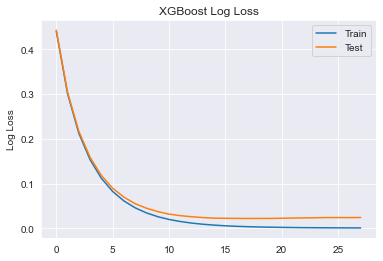

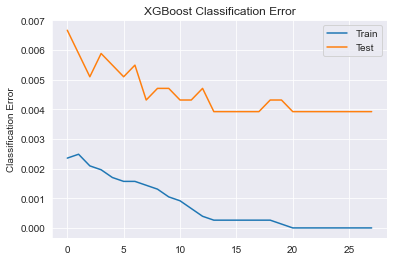

In [11]:
model=XGBClassifier()
model.fit(X_train,Y_train,eval_metric=["error","logloss"],eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose = True,early_stopping_rounds=10)
predictions=model.predict(X_test)
predictions = [round(value) for value in predictions]
accuracy=accuracy_score(Y_test,predictions)
print("Accuracy: %.2f%%" % (accuracy*100))

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

<AxesSubplot:>

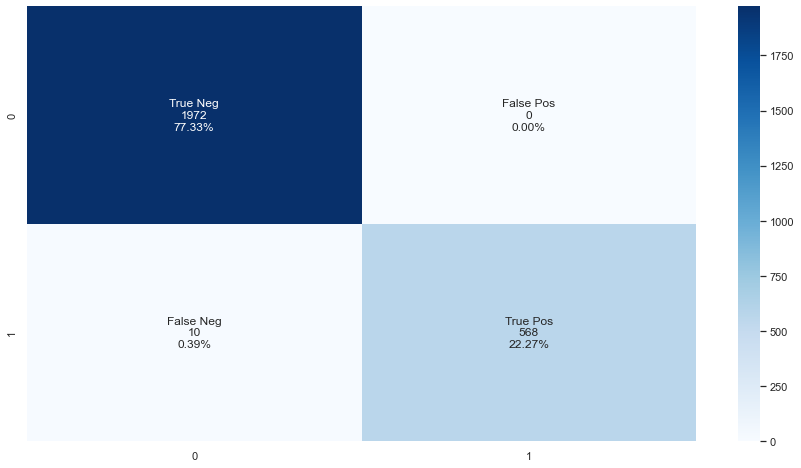

In [16]:
#create a confusion matrix with seaborn
sns.set(rc = {'figure.figsize':(15,8)})
cf_matrix = confusion_matrix(Y_test,predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

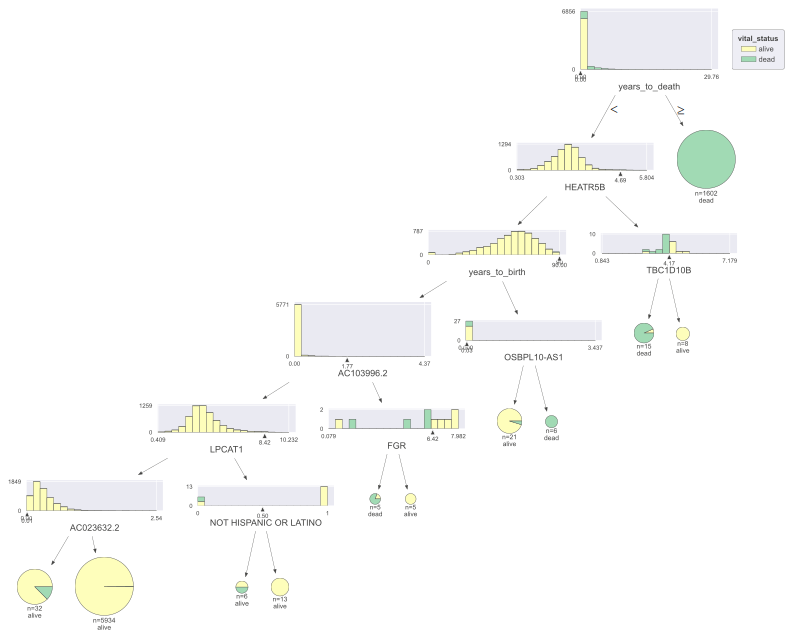

In [15]:
trees.dtreeviz(model, X_train,Y_train,  target_name= 'vital_status', feature_names= list(X_train.columns), class_names= list(label_encoder_train.classes_), tree_index=2)

In [ ]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [50]:
rcParams['figure.figsize'] = 80,40
rcParams['font.size'] = 40
rcParams['axes.labelsize'] = 60
rcParams['xtick.labelsize'] = 40
rcParams['ytick.labelsize'] = 30
rcParams['axes.titlesize'] = 80
rcParams['axes.axisbelow'] = True

<AxesSubplot:title={'center':'Gain'}, xlabel='F score', ylabel='Features'>

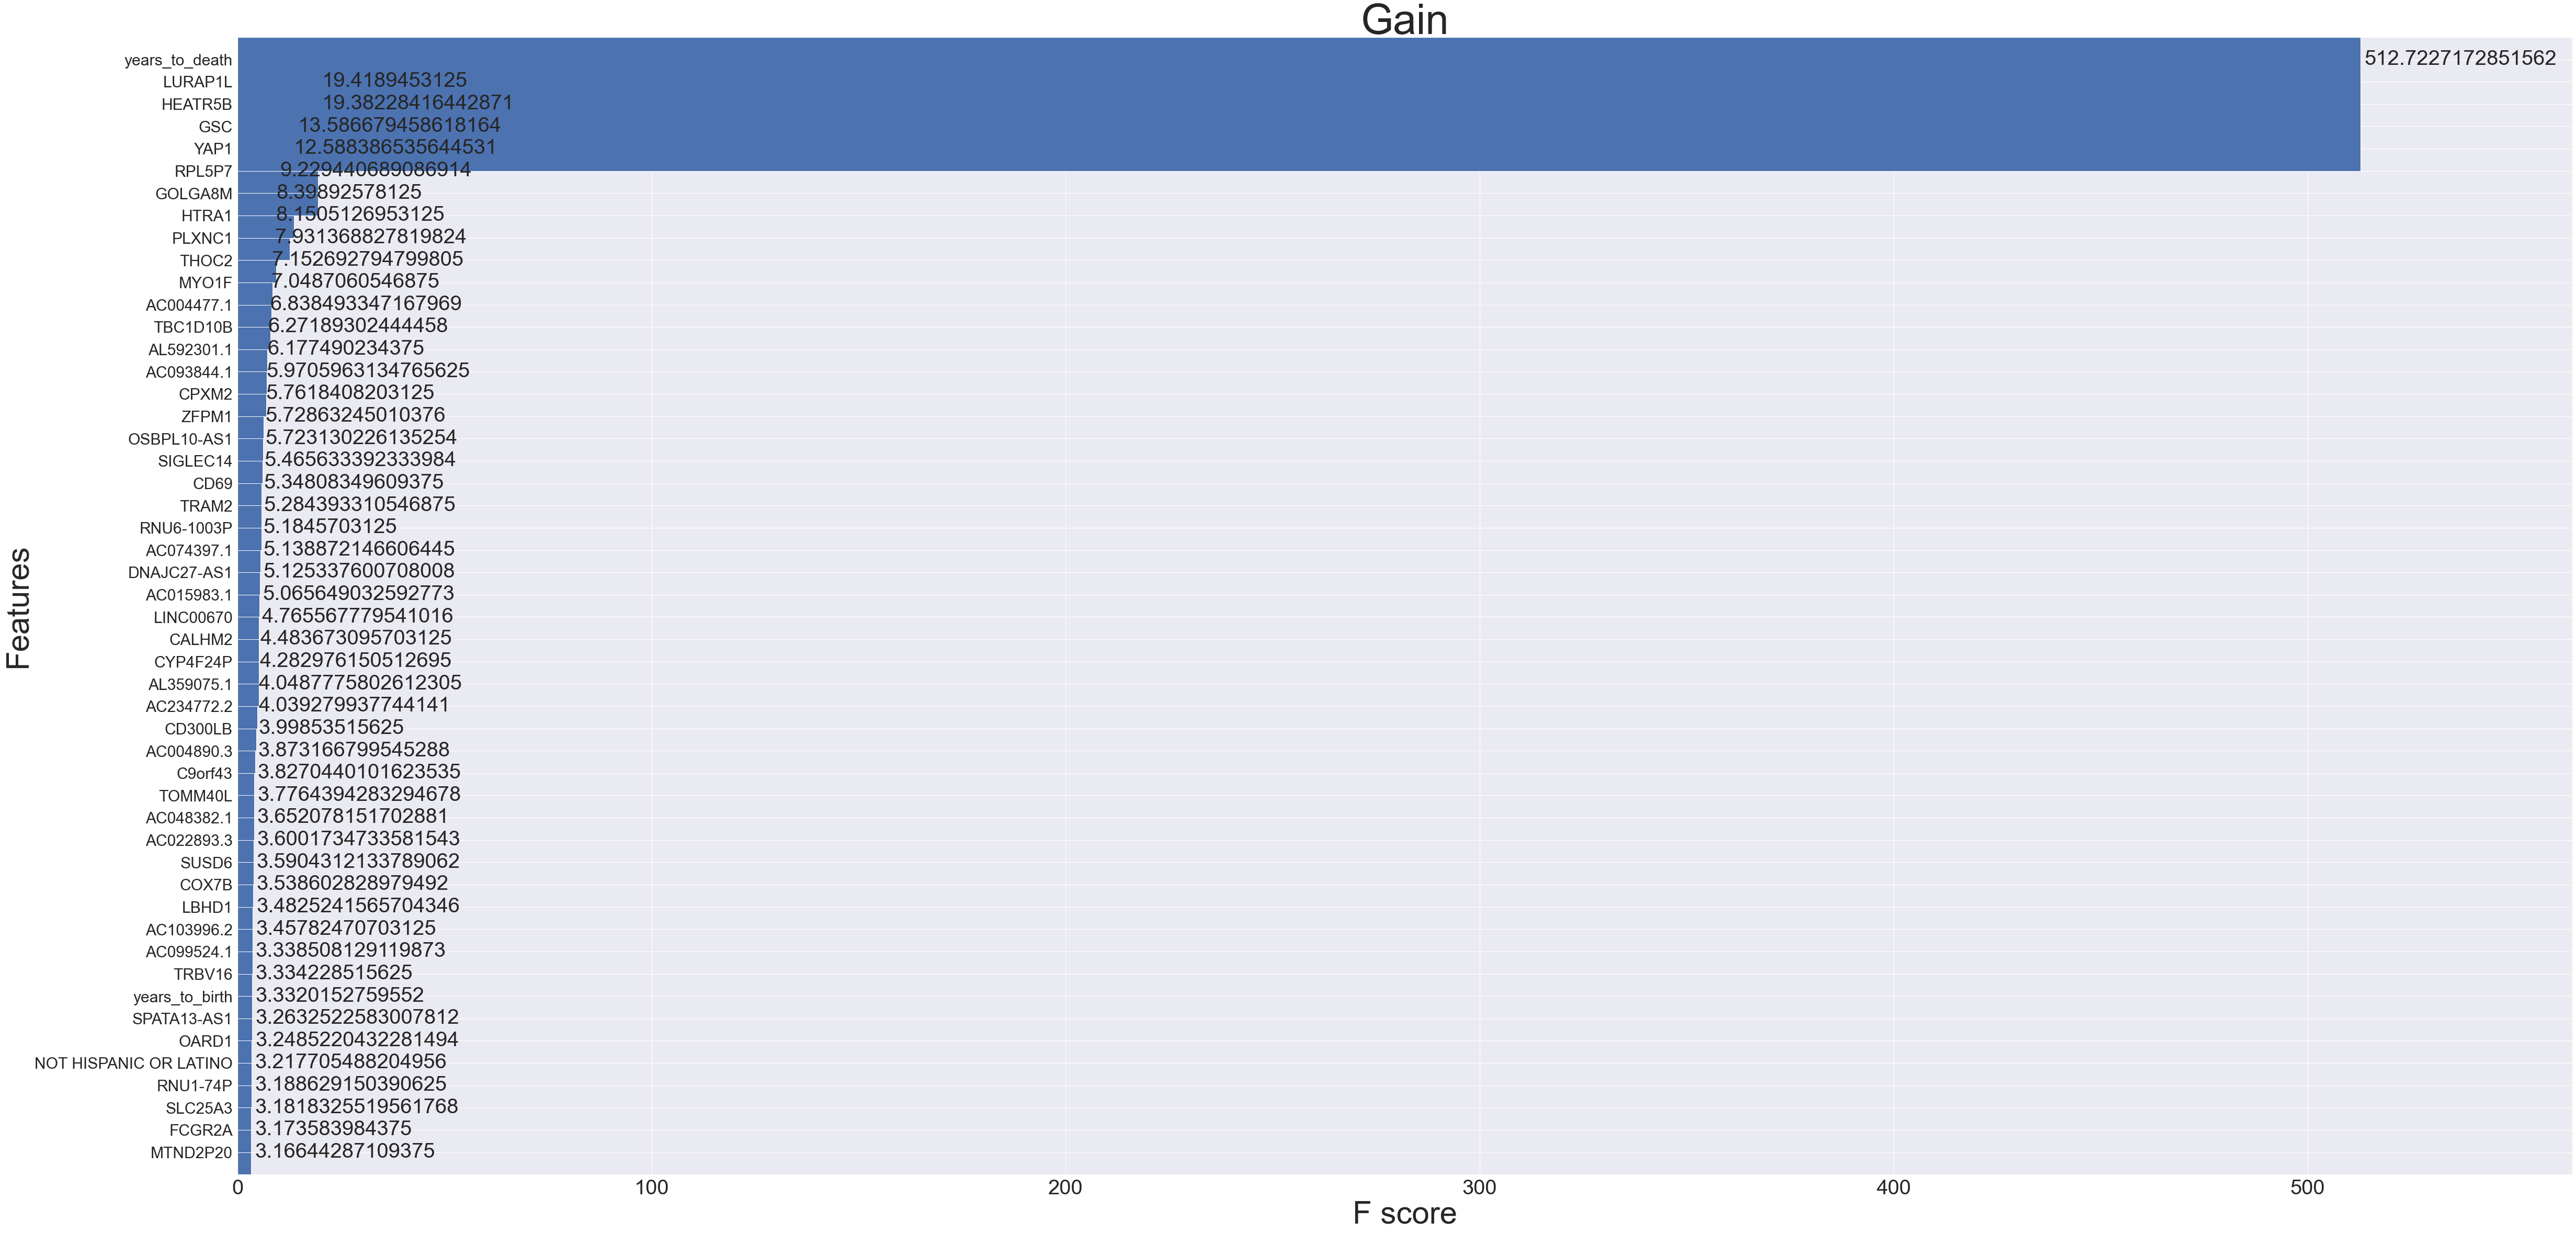

In [51]:
plot_importance(model,height=10,max_num_features=50,importance_type='gain',title='Gain')

<AxesSubplot:title={'center':'weight'}, xlabel='F score', ylabel='Features'>

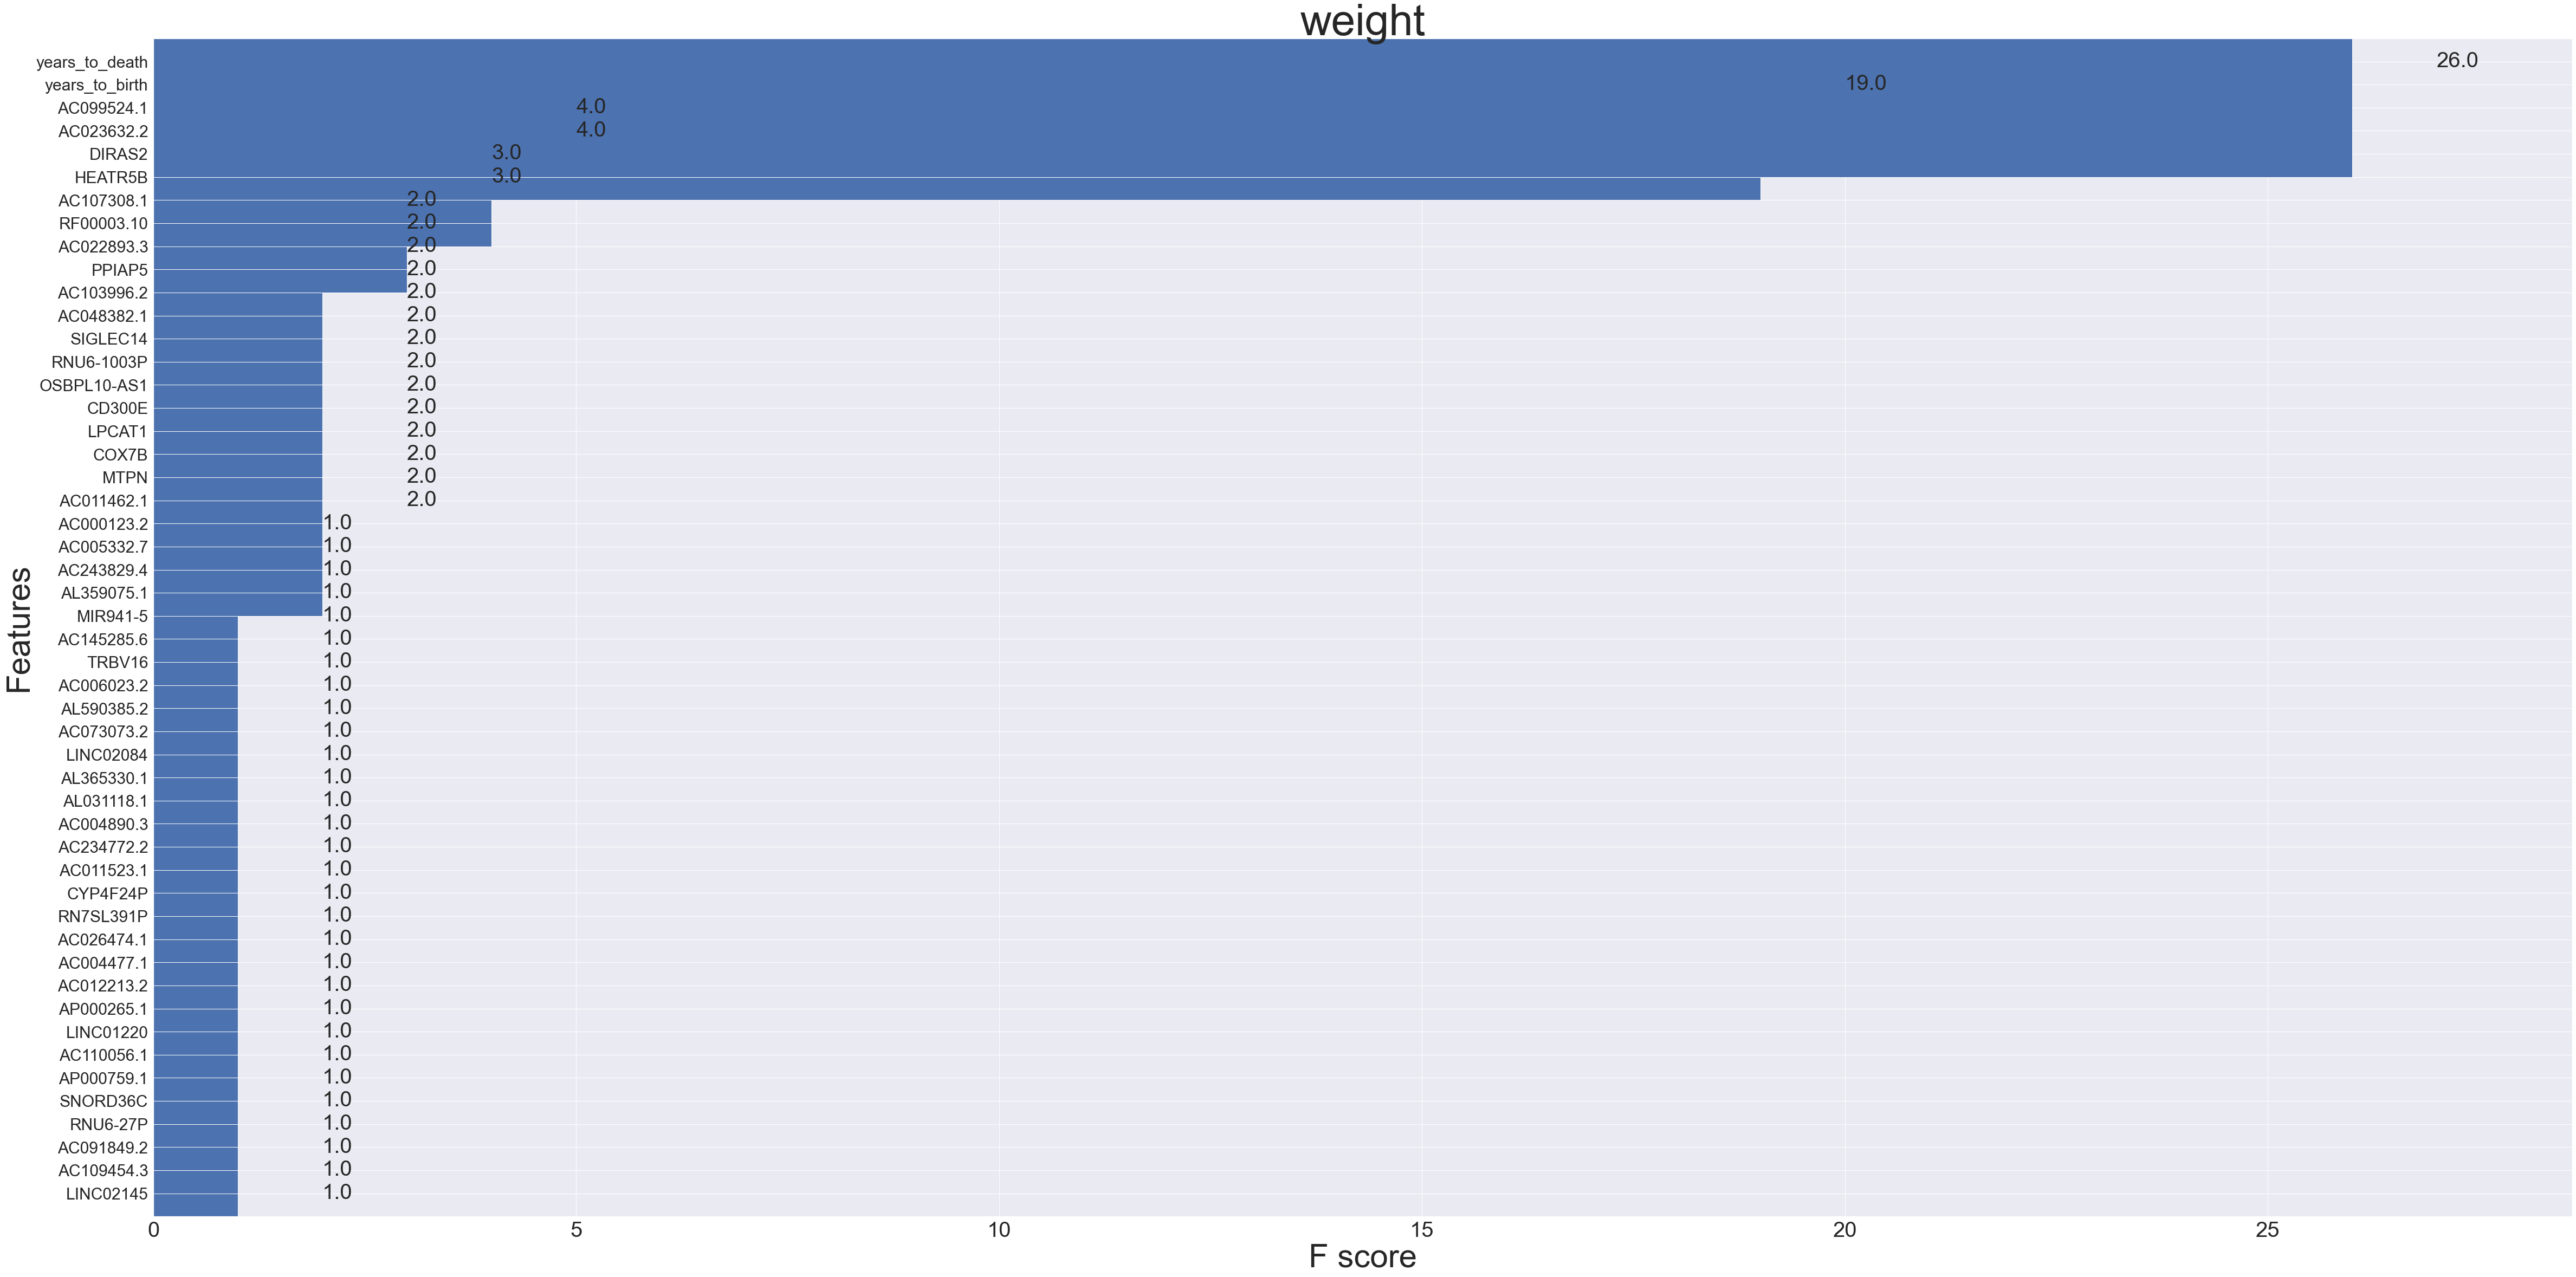

In [52]:
# plot_importance(model,importance_type='cover',height=100)
plot_importance(model,height=10,max_num_features=50,importance_type='weight',title='weight')

<AxesSubplot:title={'center':'cover'}, xlabel='F score', ylabel='Features'>

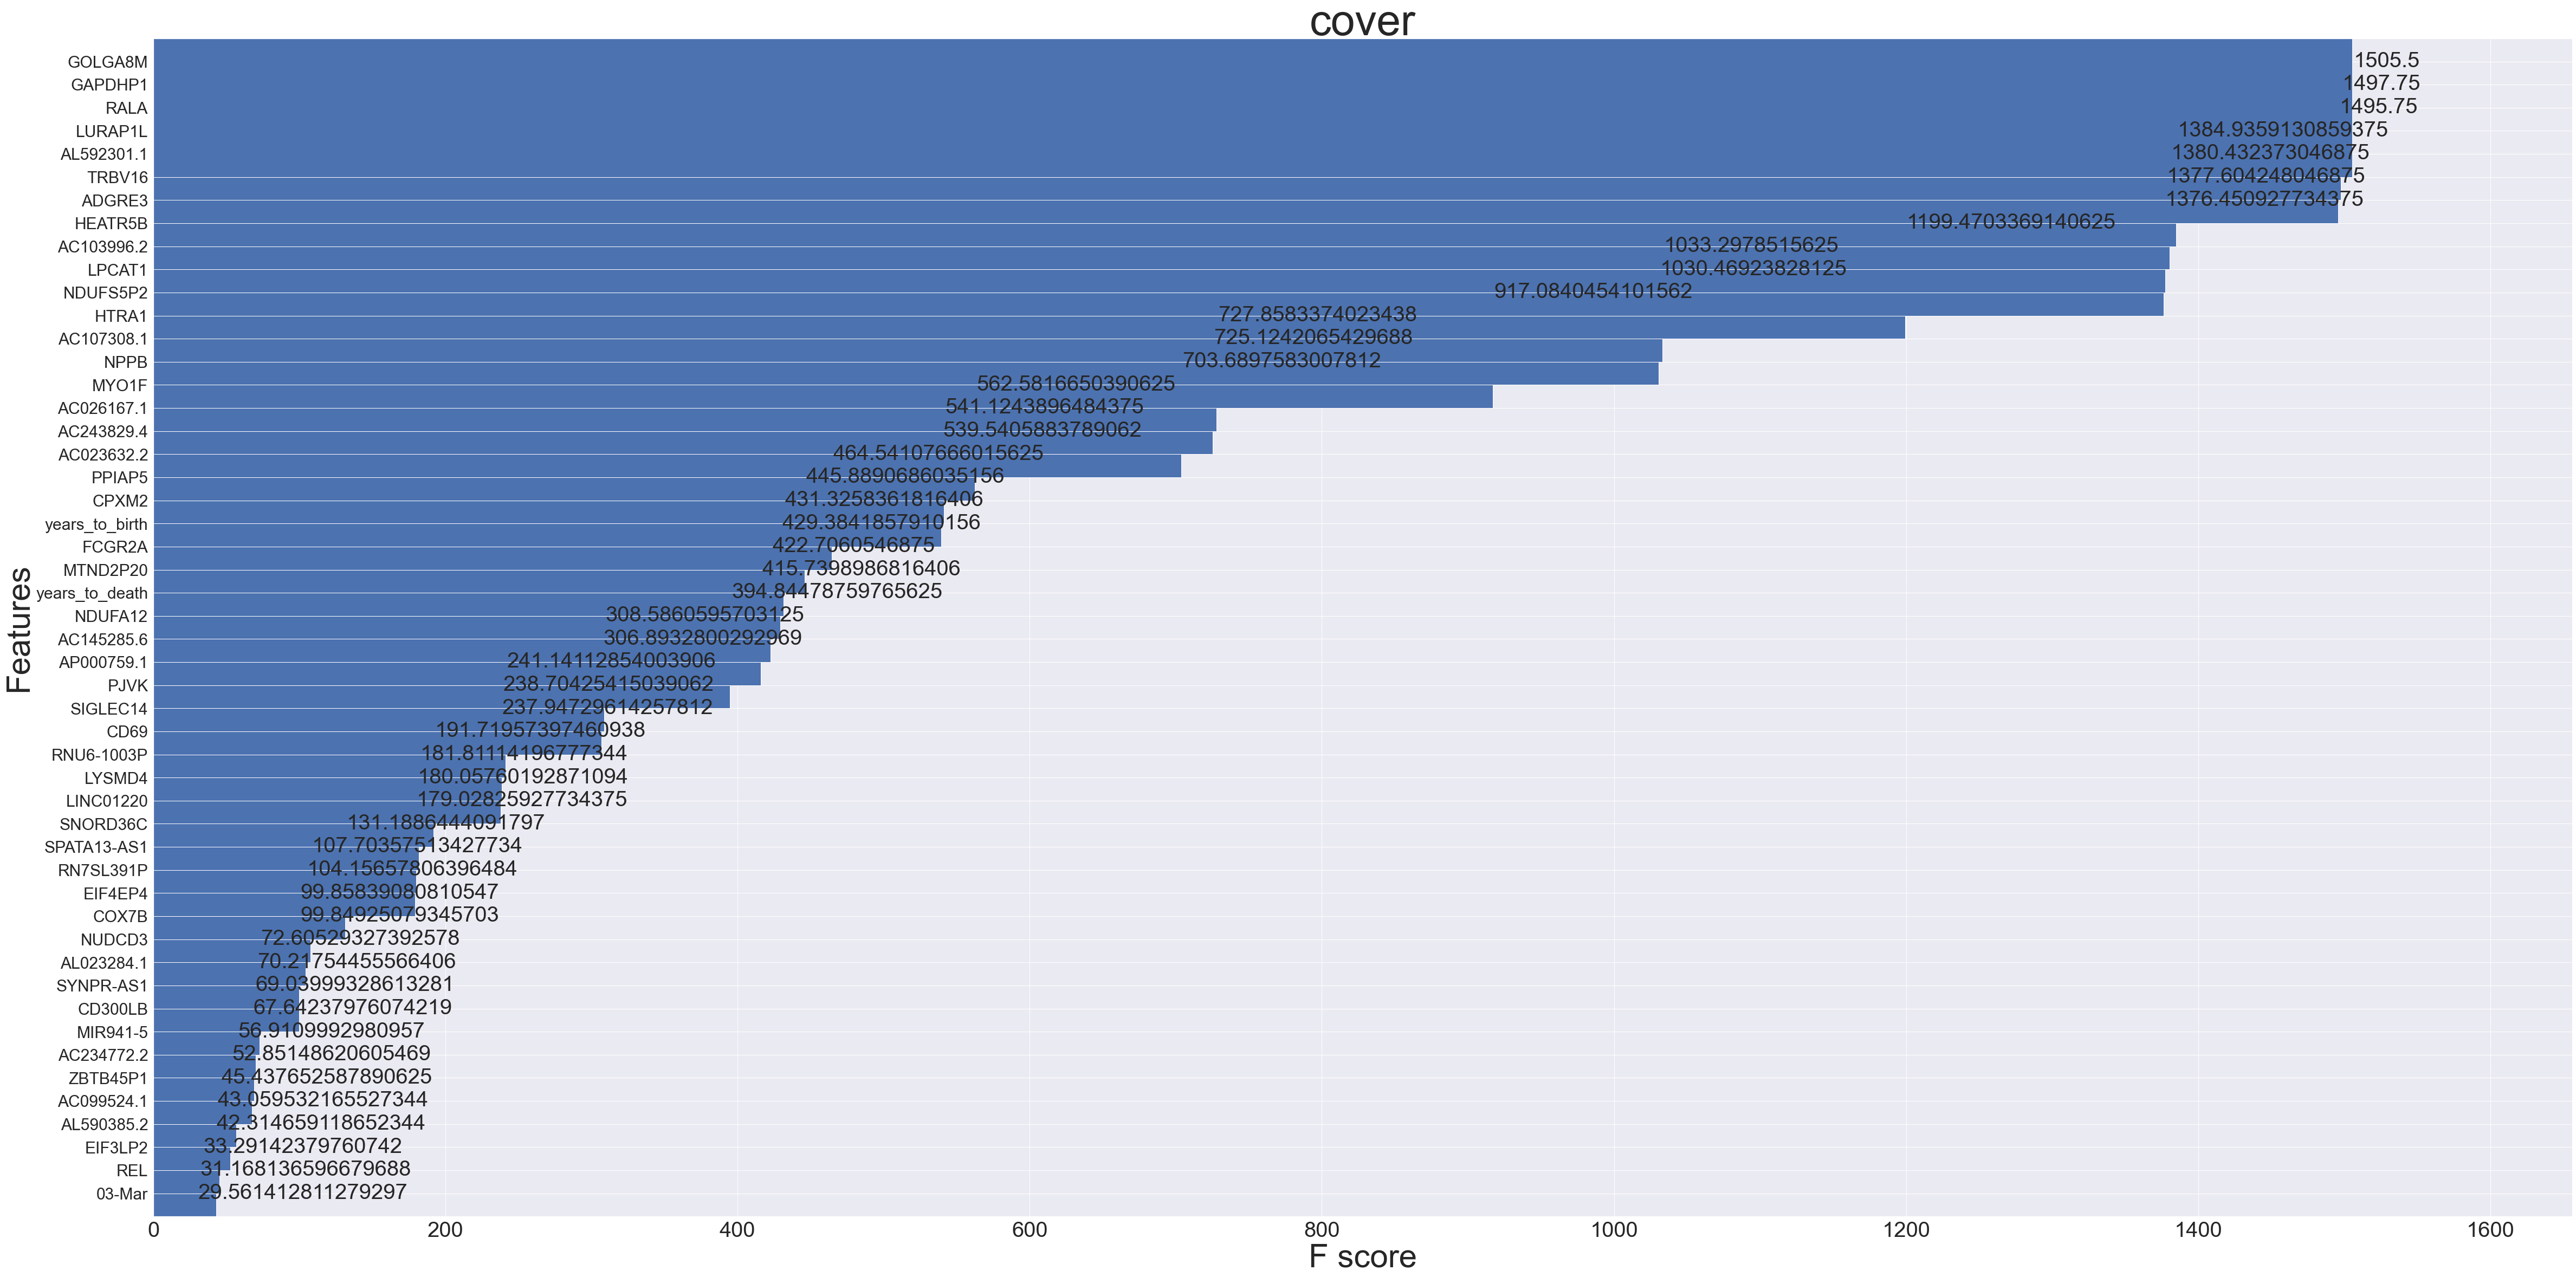

In [53]:
# plot_importance(model,importance_type='gain',height=100)
plot_importance(model,height=10,max_num_features=50,importance_type='cover',title='cover')